In [1]:
from SimPEG import *
from simpegem1d import EM1D, EM1DAnal, Kernels, RTEfun, DigFilter, BaseEM1D, Utils1D
from scipy.constants import mu_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
FDsurvey = BaseEM1D.EM1DSurveyFD()
FDsurvey.rxLoc = np.array([0., 0., 100.+30.])
FDsurvey.srcLoc = np.array([0., 0., 100.+30.])
FDsurvey.fieldtype = 'secondary'
FDsurvey.rxType = 'Hz'
FDsurvey.srcType = 'VMD'
FDsurvey.offset = np.r_[8., 8., 8.]
cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(15)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]
FDsurvey.depth = depth
FDsurvey.topo = topo
FDsurvey.LocSigZ = LocSigZ
# FDsurvey.frequency = np.logspace(3, 5, 11)
FDsurvey.frequency = np.r_[900., 7200., 56000]
FDsurvey.Nfreq = FDsurvey.frequency.size
FDsurvey.Setup1Dsystem()
FDsurvey.SetOffset()
sig_half = 1e-4
sig_blk = 1e-2
chi_half = 0.
expmap = BaseEM1D.BaseEM1DMap(mesh1D)

In [3]:
sig  = np.ones(nlay)*sig_half
blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

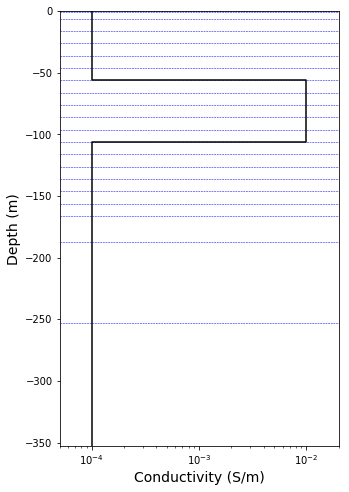

In [4]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [5]:
%%time
WT0, WT1, YBASE = DigFilter.LoadWeights()
options = {'WT0': WT0, 'WT1': WT1, 'YBASE': YBASE}
prob = EM1D.EM1D(mesh1D, sigmaMap=expmap, **options)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)
prob.CondType = 'Real'
prob.chi = np.zeros(FDsurvey.nlay)
d_true = FDsurvey.dpred(m_true)

fields
CPU times: user 24.2 ms, sys: 2.55 ms, total: 26.8 ms
Wall time: 26.8 ms


In [6]:
FDsurvey.dtrue = d_true
std = 0.05
floor = 1e-16
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
prob.jacSwitch = True

In [7]:
print d_true[:3]*np.pi*(0.1)**2/mu_0
print d_true[3:]*np.pi*(0.1)**2/mu_0

[ -2.32951861e-11  -3.10738617e-10  -7.68515822e-10]
[ -9.82042408e-11  -3.32178073e-10  -4.21126133e-10]


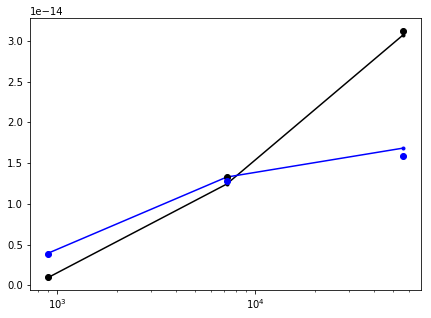

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.Nfreq], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.Nfreq:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.Nfreq], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.Nfreq:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.Nfreq], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.Nfreq:], 'r*')
axes.set_xscale('log')

In [9]:
FDsurvey.nD

6

In [10]:
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [11]:
m0 = np.log(np.ones_like(sig)*1e-3)
reg = Regularization.Tikhonov(mesh1D)
opt = Optimization.InexactGaussNewton(maxIter = 20)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**1.0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
reg.alpha_s = 1.
reg.alpha_x = 0.1
reg.alpha_y = 0.1
reg.alpha_z = 0.1

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [12]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
fields
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.07e+02  2.61e+03  0.00e+00  2.61e+03    2.53e+03      0              
fields
   1  5.33e+01  1.01e+03  5.22e+00  1.28e+03    3.69e+02      0              
fields
   2  2.66e+01  7.88e+02  8.26e+00  1.01e+03    2.77e+02      0   Skip BFGS  
fields
   3  1.33e+01  5.64e+02  1.53e+01  7.67e+02    1.70e+02      0              
fields
   4  6.66e+00  4.42e+02  2.26e+01  5.92e+02    1.11e+02      0              
fields
   5  3.33e+00  3.53e+02  3.53e+01  4.70e+02    1.01e+02      0              
fields
   6  1.67e+00  2

In [13]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :       12
  InexactGaussNewton.doStartIteration     :       12
  InexactGaussNewton.scaleSearchDirection :       12

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 4.06e-04, 1.54e-02,   38x
  EM1D.Jvec_approx                        : 4.42e-04, 1.68e-02,   38x
  InexactGaussNewton.findSearchDirection  : 1.05e-02, 1.26e-01,   12x
  InexactGaussNewton.minimize             : 4.33e+00, 4.33e+00,    1x
  InexactGaussNewton.modifySearchDirection: 2.92e-01, 3.51e+00,   12x
  InexactGaussNewton.projection           : 8.79e-05, 4.66e-03,   53x


In [22]:
dpredall = []
for i in range(len(xc)):
    dpredtemp = FDsurvey.dpred(xc[i])
    dpredall.append(dpredtemp)

fields
fields
fields
fields
fields
fields
fields
fields



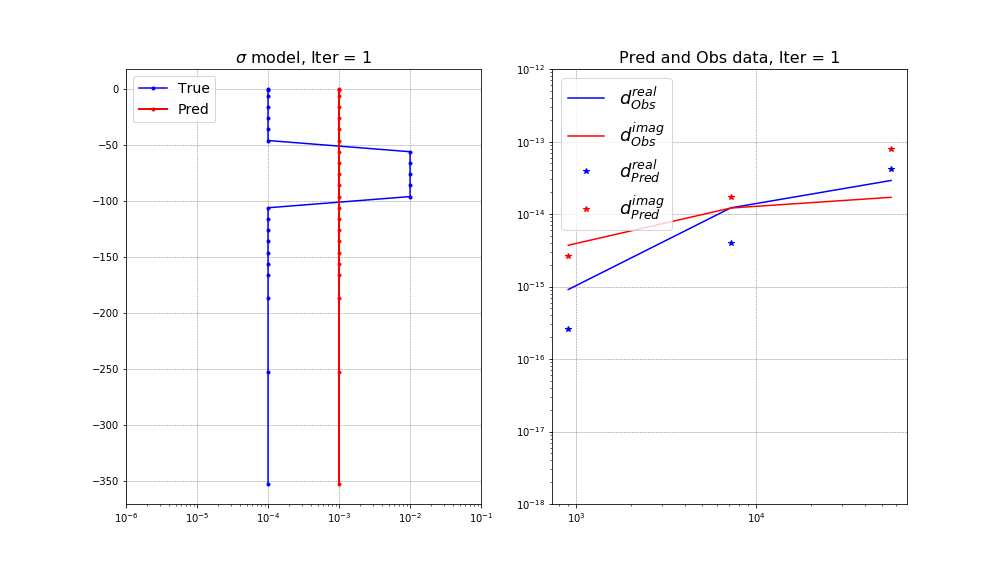
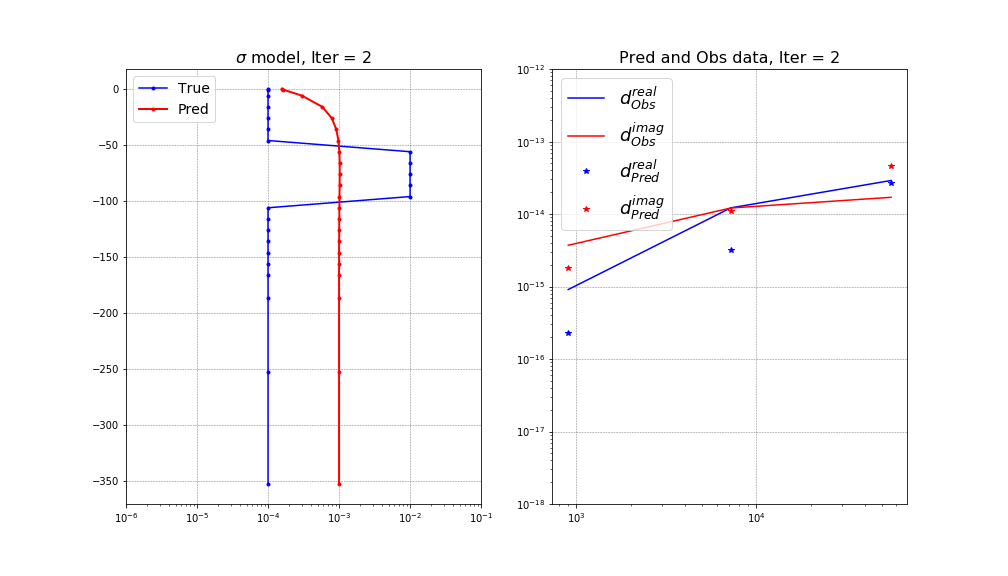
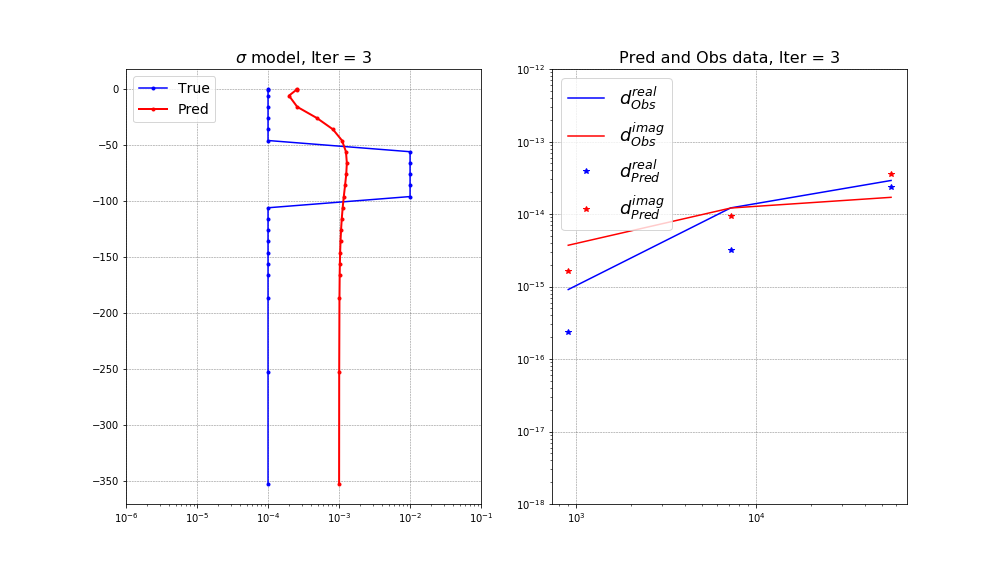
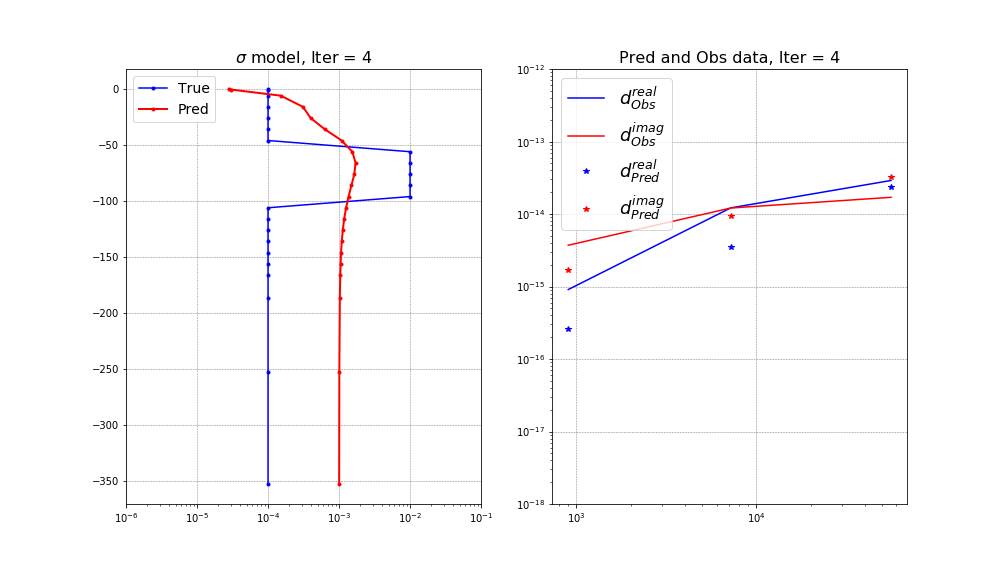
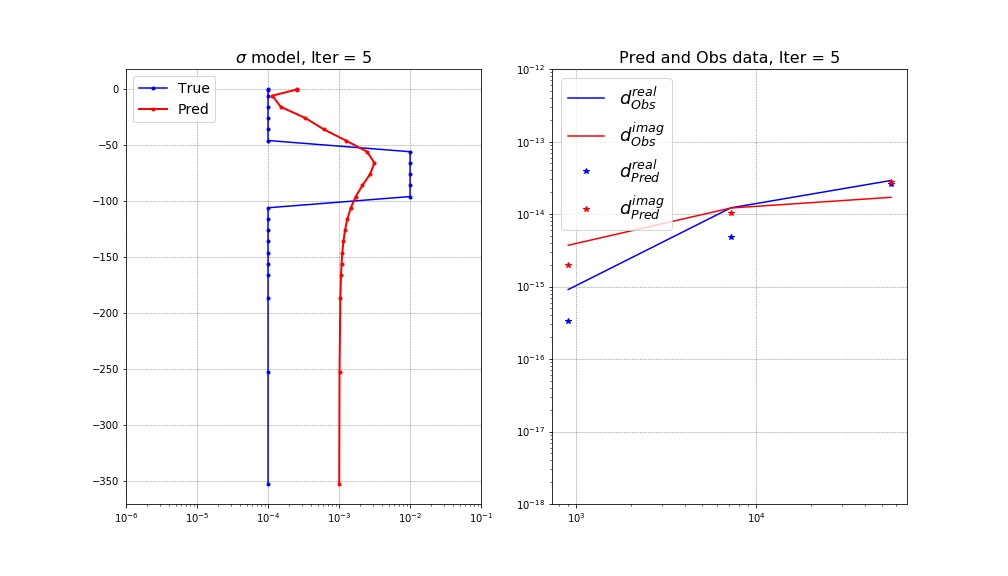
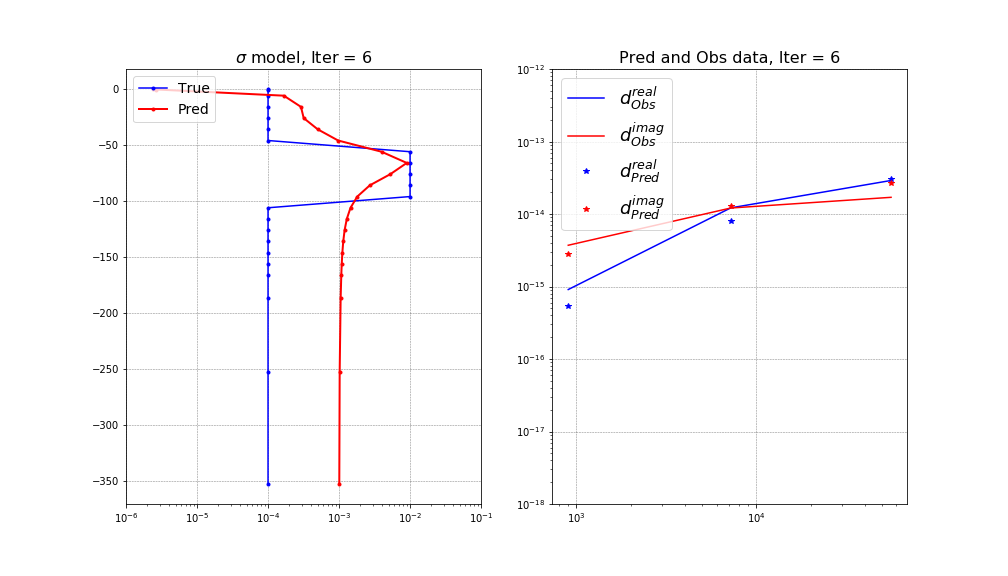
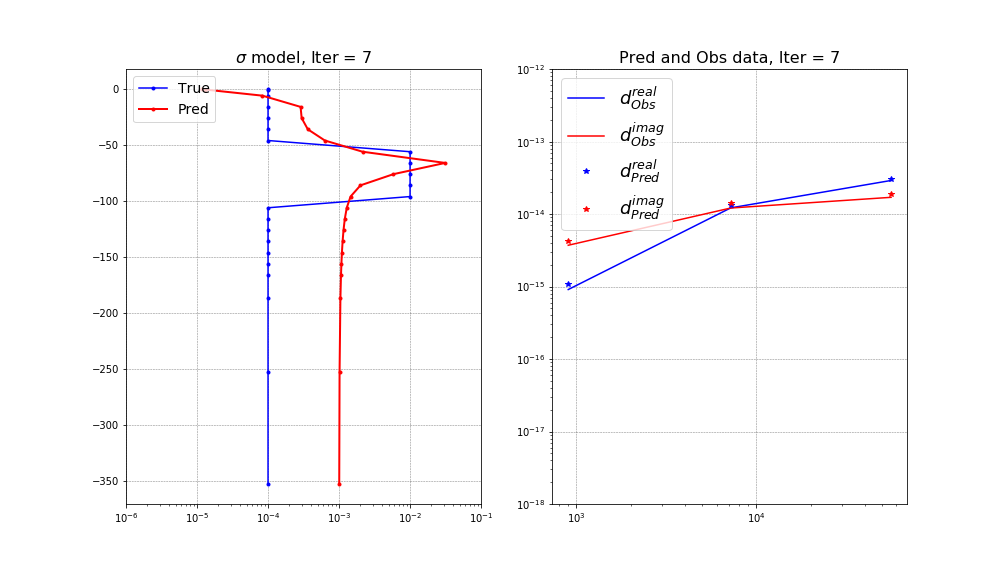
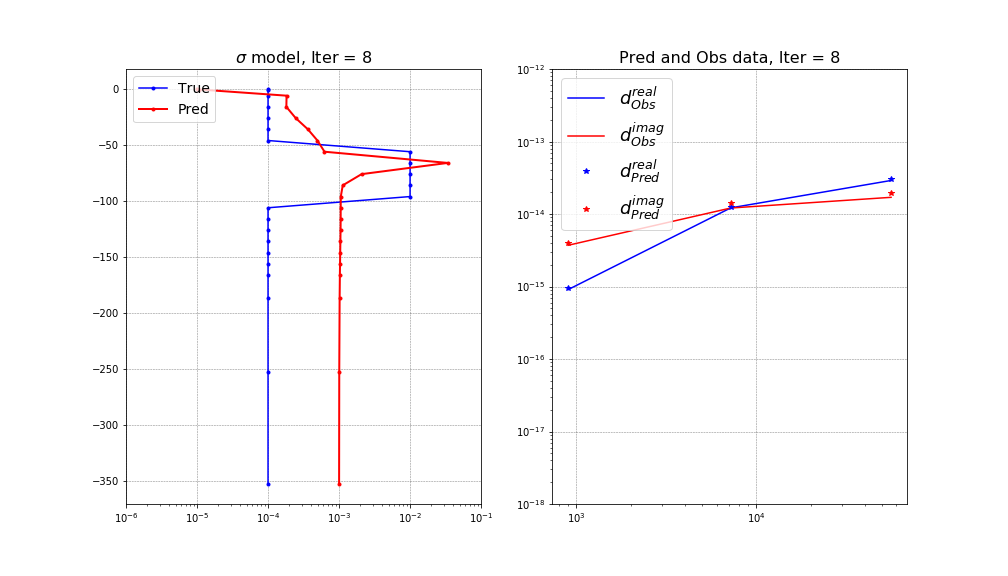

In [23]:
from JSAnimation import IPython_display
from matplotlib import animation

fig, ax = subplots(1,2, figsize=(14, 8))
ax[0].plot(sig, LocSigZ,  'b.-')
ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[0:FDsurvey.Nfreq]), 'b-')
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[FDsurvey.Nfreq:]), 'r-')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(1e-6, 1e-1)
ax[1].set_ylim(1e-18, 1e-12)

frame1, = ax[0].plot([], [],  'r.-', lw=2)
frame2, = ax[1].plot([], [],  'b*' , lw=2)
frame3, = ax[1].plot([], [],  'r*' , lw=2)

def animate(i_id):
#     
    frame1.set_data(expmap*xc[i_id], LocSigZ)
    frame2.set_data(FDsurvey.frequency, abs(dpredall[i_id][:FDsurvey.Nfreq]))
    frame3.set_data(FDsurvey.frequency, abs(dpredall[i_id][FDsurvey.Nfreq:]))
    
    ax[0].legend(('True', 'Pred'), loc=2, fontsize = 14)
    ax[1].legend(('$d^{real}_{Obs}$', '$d^{imag}_{Obs}$', '$d^{real}_{Pred}$', '$d^{imag}_{Pred}$'), loc=2, fontsize = 18)
    ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
    ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
    return frame1, frame2, frame3

animation.FuncAnimation(fig, animate, frames=len(xc), interval=40, blit=True)

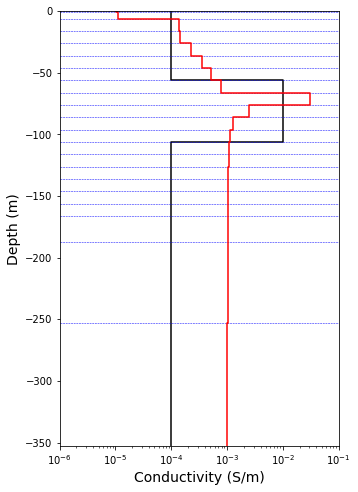

In [25]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e-1), **{'color':'r'})